In [68]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import folium
from folium.plugins import TimestampedGeoJson, AntPath
from datetime import datetime
import numpy as np
import os
import random
import math

### 旧金山出租车数据集
 共536辆车，对于每辆车，字段为[latitude，longitude，occupancy，t]


In [69]:
taxi_ids = os.listdir('./cabspottingdata')
taxi_ids = map(lambda x: x.split('.')[0], taxi_ids)
taxi_ids = list(taxi_ids)
for index, taxi_id in enumerate(taxi_ids):
    if taxi_id.startswith('new_'):
        taxi_ids[index] = taxi_id[4:]
taxi_ids = list(taxi_ids)[0:4]
print(taxi_ids)

total_df = pd.DataFrame()

for taxi_id in taxi_ids:
    # taxi_id = 'abboip'
    df = pd.read_csv(
        f"./cabspottingdata/new_{taxi_id}.txt", header=None, sep=' ')
    df.columns = ['latitude', 'longitude', 'occupancy', 't']
    # display(df.shape)
    # display(df.head())

    df.pop('occupancy')
    df.insert(0, 'id', [taxi_id for _ in range(df.shape[0])])
    df.t = df.t.apply(lambda x: datetime.fromtimestamp(x))
    chosen_index = df.t.apply(lambda x: (x.month == 5 and x.day == 18))
    df = df[chosen_index]
    df = df.sort_values(by=['t'], ascending=[True])
    df = df.set_index('t')
    total_df = pd.concat([total_df, df])
    # display(df.shape)
    # display(df.head())

# total_df.shape

# # 遍历输出每个id对应的前5个数据
# for taxi_id in taxi_ids:
#     df = total_df[total_df.id == taxi_id]
#     print(df.head())

# 将total_df，之后附在原数据后面
# for i in range(3):
#     new_df = total_df.copy()
#     randlat_change = np.random.uniform(-0.0001, 0.0001)
#     randlon_change = np.random.uniform(-0.0001, 0.0001)
#     rand_ang_change = np.random.uniform(0, 360)
#     tempx = new_df['latitude']
#     tempy = new_df['longitude']
#     new_df.id = 'new_' + new_df.id
#     new_df.latitude = tempx * np.cos(rand_ang_change * np.pi / 180) - \
#         tempy * np.sin(rand_ang_change * np.pi / 180)
#     new_df.longitude = tempx * np.sin(rand_ang_change * np.pi / 180) + \
#         tempy * np.cos(rand_ang_change * np.pi / 180)
#     new_df.latitude = new_df.latitude + randlat_change
#     new_df.longitude = new_df.longitude + randlon_change

#     total_df = pd.concat([total_df, new_df])
# new_total_df = total_df.copy()
# new_total_df.id = 'new_' + new_total_df.id
# new_total_df.latitude += 0.2
# new_total_df.longitude += .15
# total_df = pd.concat([total_df, new_total_df])

['abboip', 'abcoij', 'abdremlu', 'abgibo']


In [70]:
gdf = gpd.GeoDataFrame(total_df, geometry=gpd.points_from_xy(total_df.longitude, total_df.latitude), crs=4236)
trajs = mpd.TrajectoryCollection(gdf, 'id')

trajs

TrajectoryCollection with 4 trajectories

总共有224个轨迹


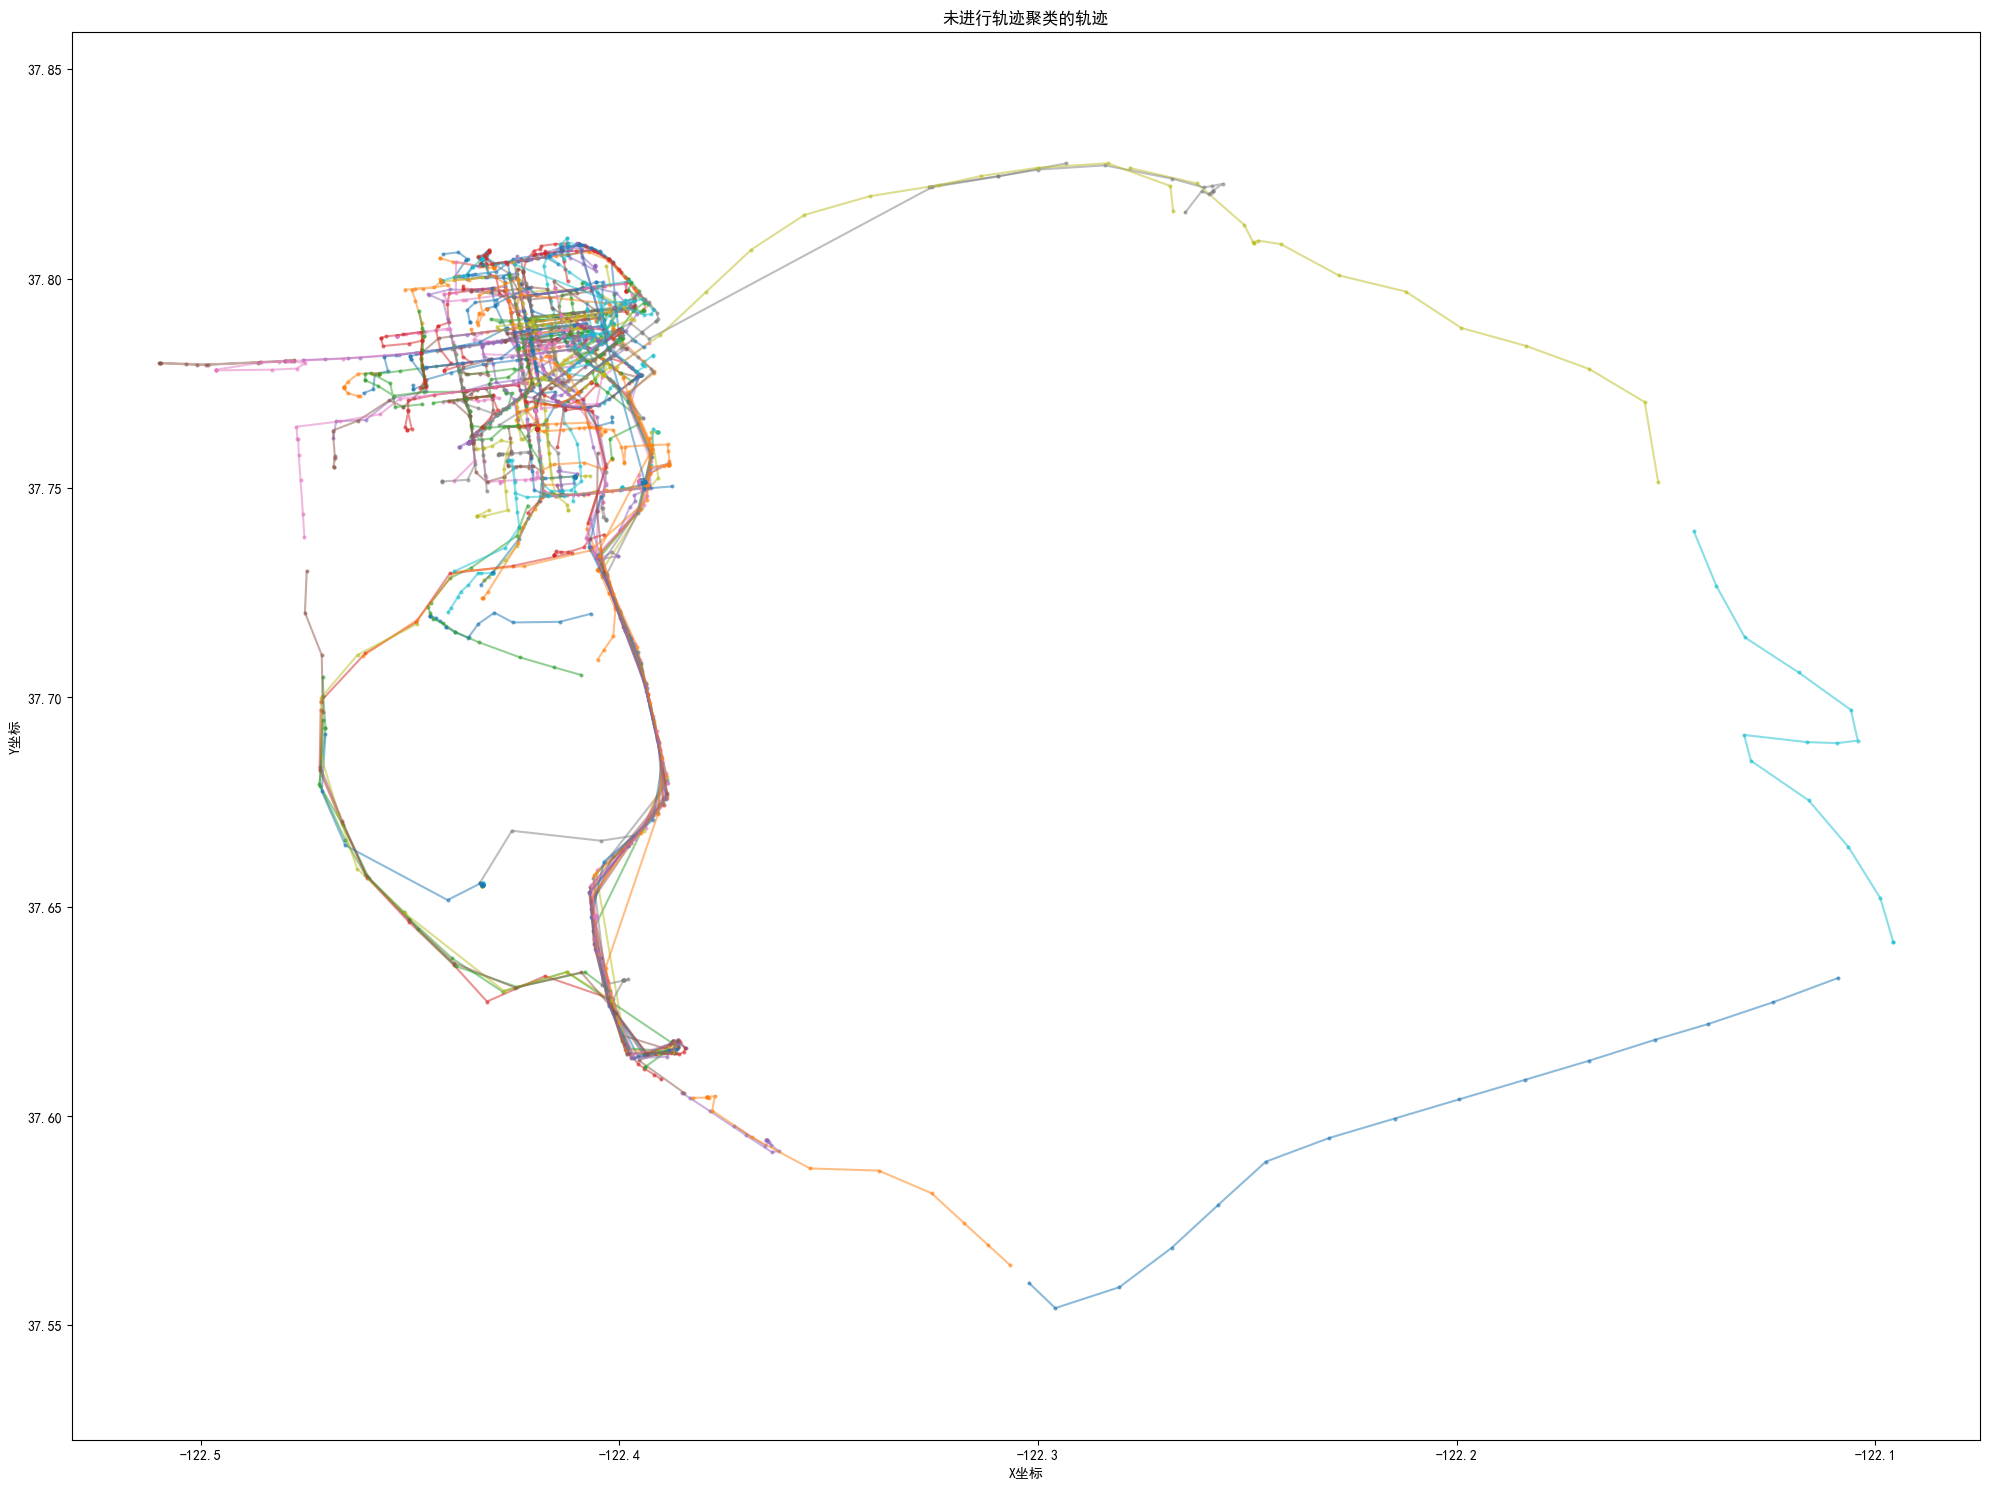

In [71]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from shapely.geometry import Point
import random
# 设置随机数种子
random.seed(42)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号



# 提取轨迹点并进行聚类，每个轨迹用一个数组储存
coords = []
for traj in trajs.trajectories:
    points = [(p.geometry.x, p.geometry.y) for p in traj.df.itertuples()]
    traj_len = 15
    while len(points) > traj_len:
        coords.append(points[:traj_len])
        points = points[traj_len:]

# 对所有的点进行随机平移和旋转，生成新的轨迹点
center_point = (0, 0)
for traj in coords:
    center_point = (center_point[0] + traj[0][0], center_point[1] + traj[0][1])
center_point = (center_point[0] / len(coords), center_point[1] / len(coords))



new_coords = []
angle_range = 80
shift_range = 0.2
# for i in range(3):
#     x_shift = random.uniform(-shift_range, shift_range)
#     y_shift = random.uniform(-shift_range, shift_range)
#     angle = random.uniform(-angle_range, angle_range)
#     index = 0
#     for traj in (coords):
#         index += 1
#         new_traj = []
#         if index % 10 == 0:
#             x_shift = random.uniform(-shift_range, shift_range)
#             y_shift = random.uniform(-shift_range, shift_range)
#             angle = random.uniform(-angle_range, angle_range)
#         for point in traj:
#             new_point = (point[0] + x_shift, point[1] + y_shift)
#             new_point_x, new_point_y = new_point
#             # 让new_point绕center_point旋转angle度
#             new_point_x_rotated = (new_point_x - center_point[0]) * \
#                 math.cos(angle / 180 * math.pi) - (new_point_y - center_point[1]) * \
#                 math.sin(angle / 180 * math.pi) + center_point[0]
#             new_point_y_rotated = (new_point_x - center_point[0]) * \
#                 math.sin(angle / 180 * math.pi) + (new_point_y - center_point[1]) * \
#                 math.cos(angle / 180 * math.pi) + center_point[1]
#             new_point = (new_point_x_rotated, new_point_y_rotated)
#             new_traj.append(new_point)
#         new_coords.append(new_traj)

# print(f"总共有{len(new_coords)}个轨迹")
# coords = new_coords


print(f"总共有{len(coords)}个轨迹")

# 绘制未聚类的轨迹
plt.figure(figsize=(20, 15))
for idx, traj in enumerate(coords):
    
    x, y = zip(*traj)
    color = f"C{idx}"
    plt.plot(x, y, marker="o", linestyle="-",
             color=color, label=f"轨迹 {idx + 1}", alpha=0.5, markersize=2)
plt.xlabel("X坐标")
plt.ylabel("Y坐标")
plt.axis("equal")
plt.title("未进行轨迹聚类的轨迹")
# plt.legend()
plt.tight_layout()
plt.show()


In [72]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
from tqdm import tqdm as tqdm

# x = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5]])
# y = np.array([[2, 2], [3, 3], [4, 4]])

dis_matrix_dtw = np.zeros((len(coords), len(coords)))
def dtw_distance(x, y):
    return fastdtw(x, y, dist=euclidean)[0]

with tqdm(total=len(coords)**2) as pbar:
    for i in range(len(coords)):
        for j in range(len(coords)):
            pbar.update(1)
            dis_matrix_dtw[i][j] = dtw_distance(coords[i], coords[j])

# def euclidean_distance(x, y):
#     x = np.array(x)
#     y = np.array(y)
#     return np.sqrt(np.sum((x - y)**2))


# dis_matrix_euclidean = np.zeros((len(coords), len(coords)))
# with tqdm(total=len(coords)**2) as pbar:
#     for i in range(len(coords)):
#         for j in range(len(coords)):
#             pbar.update(1)
#             dis_matrix_euclidean[i][j] = euclidean_distance(
#                 coords[i], coords[j])


# 测试一下

# print(dtw_distance(x, y))
# print(dis_matrix_euclidean)

100%|██████████| 50176/50176 [02:07<00:00, 394.15it/s]


C:\Users\yunhe\AppData\Local\Temp\ipykernel_12932\709191610.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


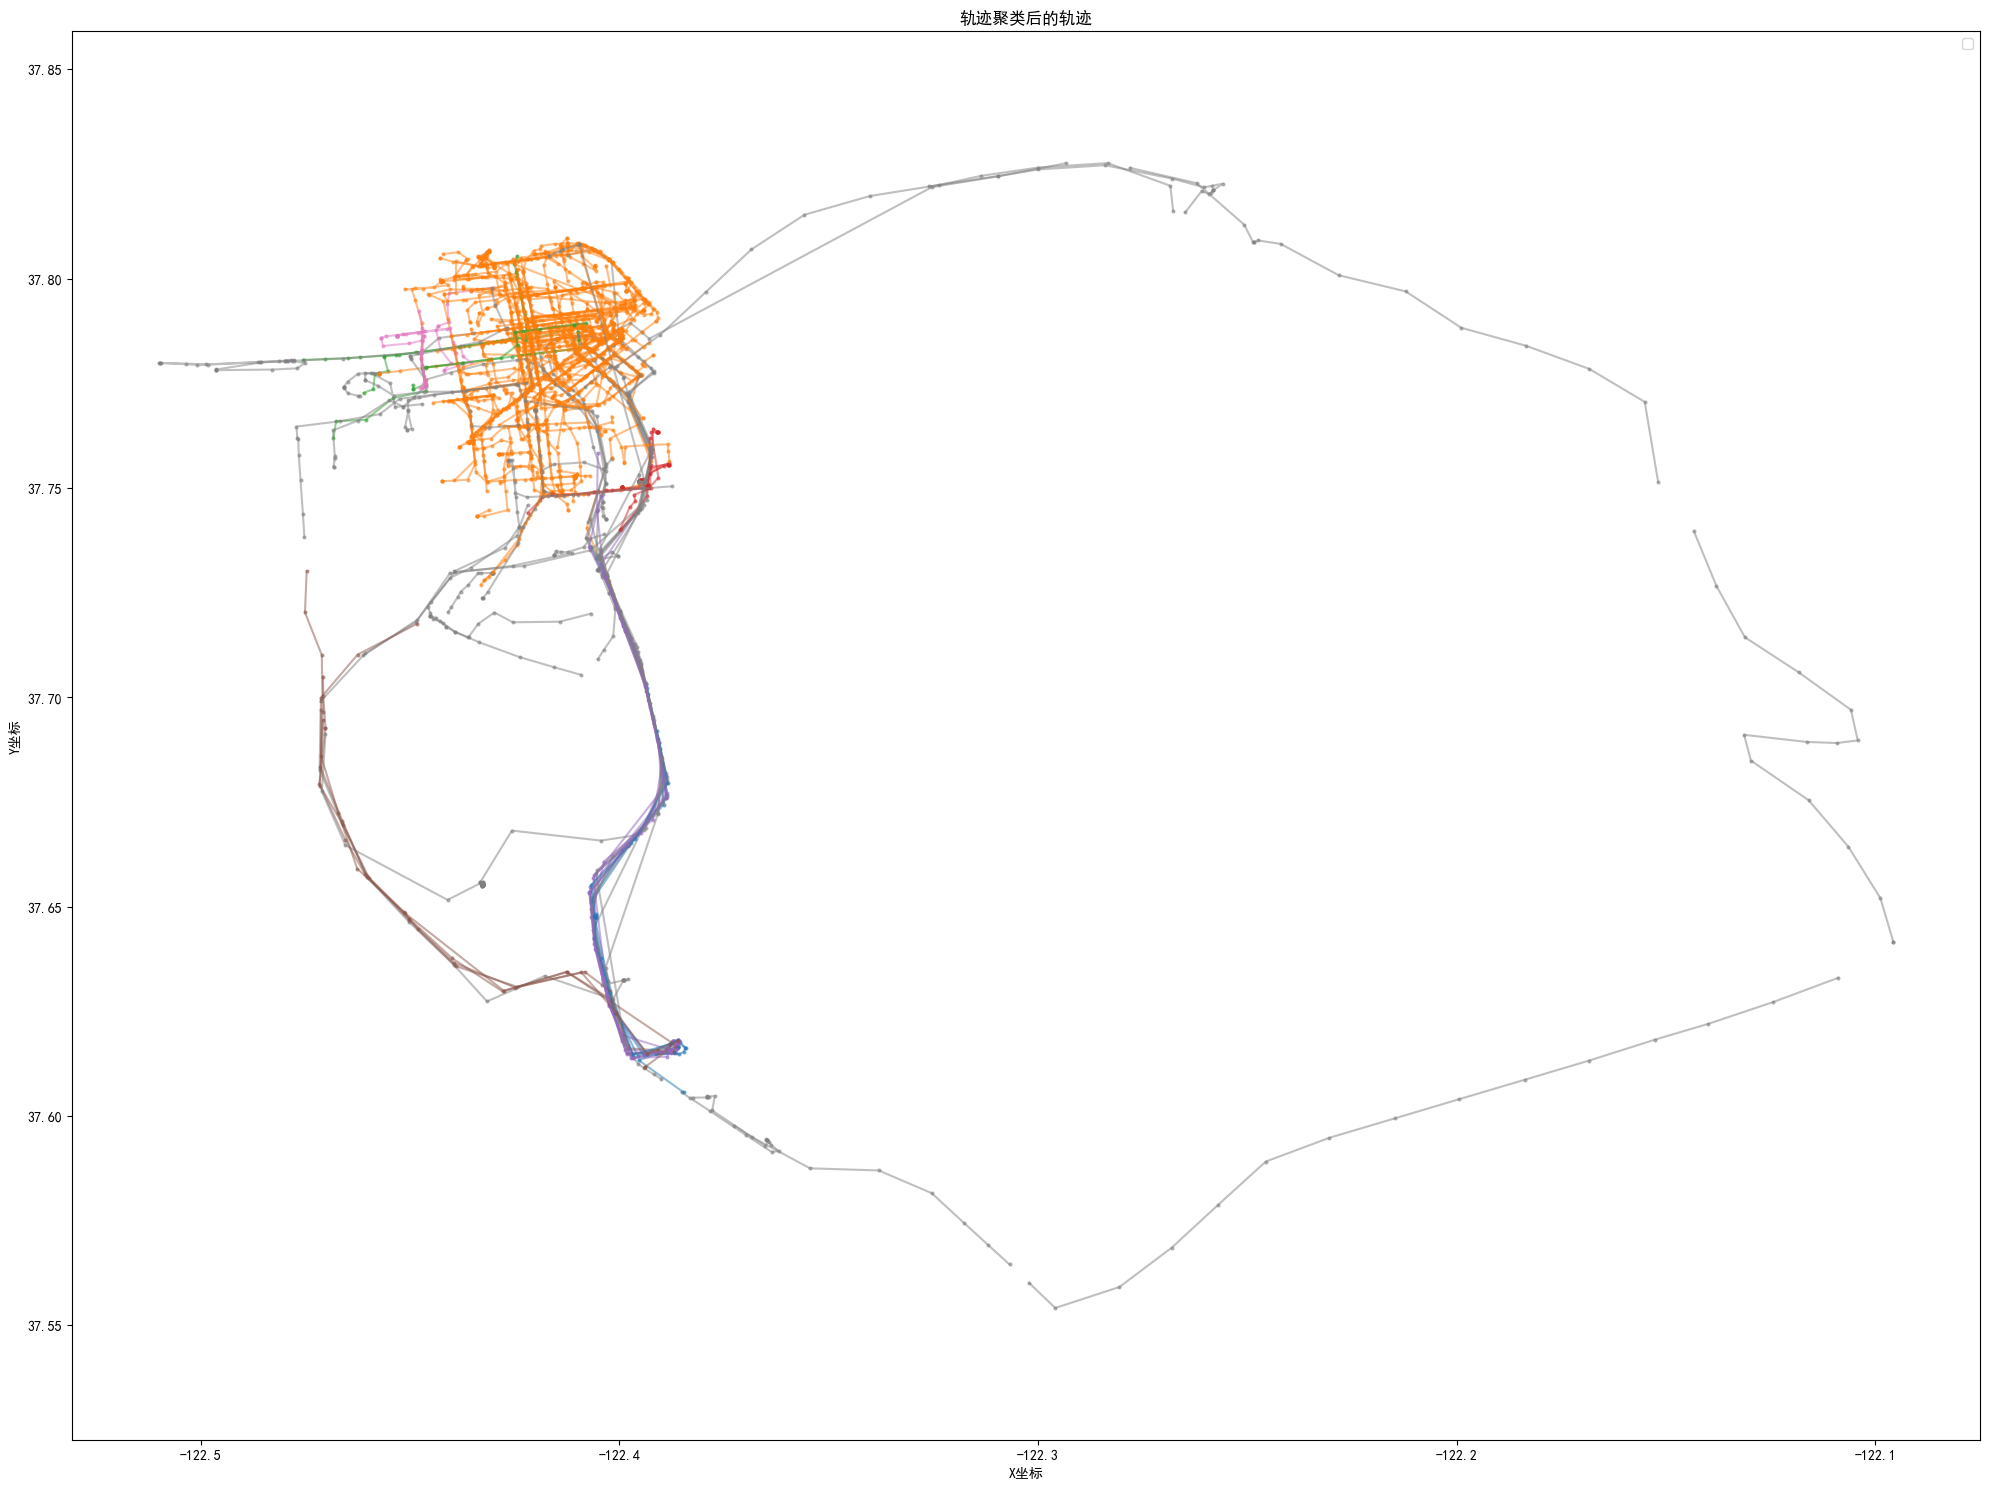

In [73]:
dbscan = DBSCAN(eps=0.15, min_samples=4, metric="precomputed")
dbscan.fit(dis_matrix_dtw)
# print(dbscan.labels_)

lables = dbscan.labels_.copy()
# 绘制聚类后的轨迹
plt.figure(figsize=(20, 15))
for idx, traj in enumerate(coords):
    
    x, y = zip(*traj)
    color = f"C{lables[idx]}" if lables[idx] >= 0 else "gray"
    plt.plot(x, y, marker="o", linestyle="-",
             color=color, alpha=0.5, markersize=2)
plt.xlabel("X坐标")
plt.axis("equal")
plt.ylabel("Y坐标")
plt.legend()
plt.title("轨迹聚类后的轨迹")
# plt.legend()
plt.tight_layout()
plt.show()

In [74]:
# start_point = trajs.trajectories[0].get_start_location()
# print(start_point)
# m = folium.Map(location=[start_point.y, start_point.x], tiles="cartodbpositron", zoom_start=14)
# m.add_child(folium.LatLngPopup())
# minimap = folium.plugins.MiniMap()
# m.add_child(minimap)
# folium.TileLayer("OpenStreetMap").add_to(m)


# for index, traj in enumerate(trajs.trajectories):
#     name = f"Taxi {traj.df['id'].iloc[0]}"
#     randr = lambda: np.random.randint(0, 255)
#     color = "#%02X%02X%02X" % (randr(), randr(), randr())
    
#     geo_col = traj.to_point_gdf().geometry
#     xy = [[y, x] for x, y in zip(geo_col.x, geo_col.y)]
#     f1 = folium.FeatureGroup(name)
#     AntPath(
#         locations=xy,
#         dash_array=[20, 30],
#         weight=3,
#         opacity=0.8,
#         color=color,
#     ).add_to(f1)
#     f1.add_to(m)
# folium.LayerControl().add_to(m)

# m.get_root().render()
# m.get_root().save("map.html")